**Tabla de contenido**

- [Librerías](#Librerias)
- [Lectura de datos](#Lectura-de-datos)
- [Modelado](#Modelado)
- [Forescating](#Forescating)

El objetivo del proyecto en este capítulo es pronosticar el número de recetas de medicamentos antidiabéticos en Australia, desde 1991 hasta 2008. En un entorno profesional, resolver este problema nos permitiría evaluar la producción de medicamentos antidiabéticos, como producir lo suficiente para satisfacer la demanda y también evitar la sobreproducción.

Para resolver este problema siga los siguientes pasos:
1. El objetivo es predecir 12 meses de prescripciones de medicamentos antidiabéticos. Utilice los últimos 36 meses del conjunto de datos como un conjunto de prueba para permitir pronósticos en ventana deslizante. 
2. Visualice la serie temporal. 
3. Utilice la descomposición de series temporales para extraer la tendencia y los componentes estacionales. 
4. Basado en su exploración, determine el modelo más adecuado.
5. Modela la serie con los pasos habituales: 
    - Aplica transformaciones para hacerla estacionaria 
    - Establece los valores de d y D. Establece el valor de m. 
    - Encuentra los parámetros óptimos (p,d,q)(P,D,Q)m. 
    - Realiza un análisis residual para validar tu modelo.
6. Realiza pronósticos continuos de 12 meses en el conjunto de prueba. 
7. Visualiza tus pronósticos. 
8. Compara el desempeño del modelo con una línea base. Selecciona una línea base y una métrica de error apropiadas. 
9. Concluye si el modelo debería ser utilizado o no.

`Para aprovechar al máximo este proyecto final, se te anima encarecidamente a completarlo por tu cuenta, refiriéndote a los pasos anteriores. Esto te ayudará a evaluar tu autonomía en el proceso de modelado y tu comprensión.`



# Librerias

In [1]:
import pandas as pd
import os

# Lectura de datos

In [2]:
file_path = lambda file: os.path.join(os.getcwd(),'data',file)
df = pd.read_csv(file_path('AusAntidiabeticDrug.csv'))
df.head()

,ds,y
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


Podemos observar que tenemos datos registrados mensualmente. Esto indica que la frecuencia es 12. Ya que en un año hay 12 meses. Veamos la serie temporal.

# EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ds      204 non-null    object 
 1   y       204 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.3+ KB


No hay valores faltantes y la fecha no está en formato datetime, corrijamos esto.

In [4]:
df['ds']= pd.to_datetime(df['ds'], format='%Y-%m-%d')
df.head()

,ds,y
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


Veamos la serie temporal.

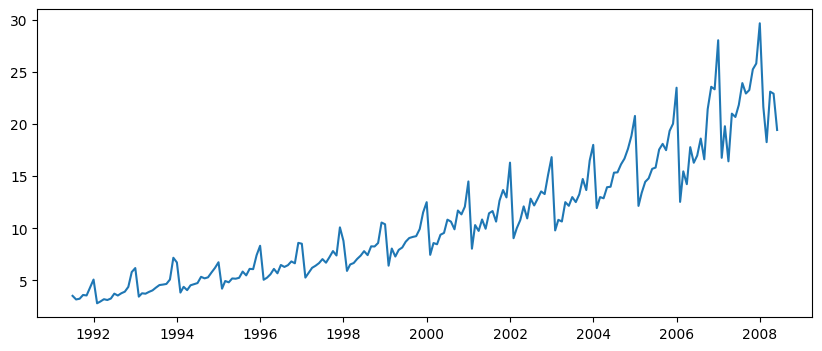

In [5]:
import matplotlib.pyplot as plt
#plt.figure(figsize=(ancho, alto))
plt.figure(figsize=(10, 4))
plt.plot(df['ds'],df['y'])

Podemos observar lo siguiente:
1. La serie tiene tendencia 
2. La serie tiene patrones que se repiten en el tiempo

Descomponer la serie en sus tres componentes prinicipales: tendencia, estacionalidad, residuo.

Para esto usaremos la función STL de statsmodel, en donde el periodo es 12, pues los datos son mensuales y en un año solo hay 12 meses.

Text(0, 0.5, 'Residuals')

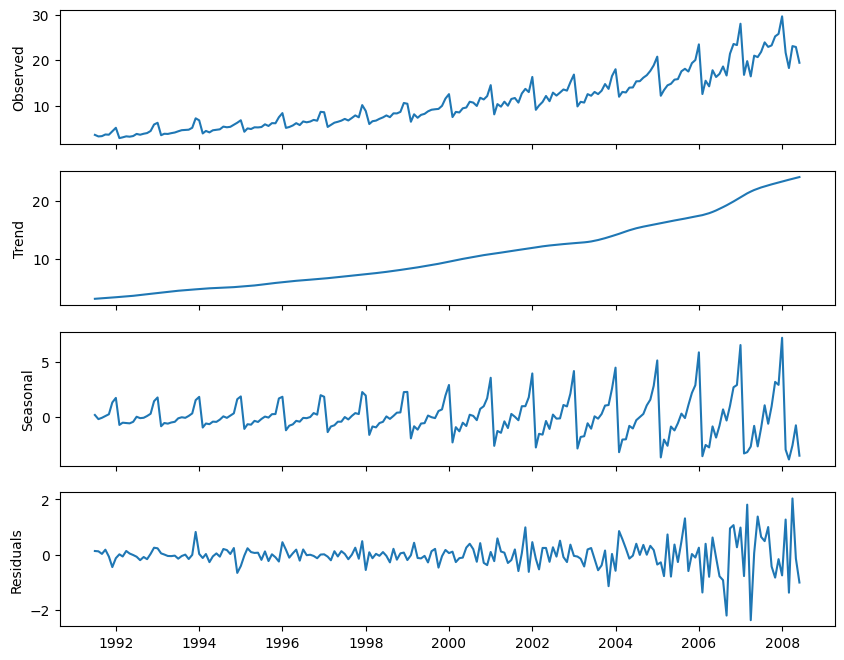

In [6]:
from statsmodels.tsa.seasonal import STL
df = df.set_index('ds',drop=True)
decomposition = STL(df['y'], period=12).fit()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True,figsize=(10,8))
ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')
ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')
ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')
ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

Podemos observar que el primer gráfico muestra los datos observados. El segundo gráfico muestra el componente de tendencia, que nos indica que el número de prescripciones de medicamentos antidiabéticos está aumentando con el tiempo. El tercer gráfico muestra el componente estacional, donde podemos ver un patrón repetido a lo largo del tiempo, lo que indica la presencia de estacionalidad. El último gráfico muestra los residuos, que son variaciones que no son explicadas por la tendencia del componente estacional.

# Modelado

Dado que hemos elegido el modelo SARIMA, vamos a implementar los siguientes pasos:

![Paso](fig/sarimamodel.png)

In [7]:
from statsmodels.tsa.stattools import adfuller
# Verifica estacionariedad
ad_fuller_result = adfuller(df['y'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 3.145185689306745
p-value: 1.0


Esto imprime una estadística ADF de 3.14 y un valor p de 1.0. Por lo tanto, no podemos rechazar la hipótesis nula y la serie no es estacionaria. Vamos a diferenciar la serie y probar la estacionariedad nuevamente.

In [8]:
import numpy as np
df_diff = np.diff(df['y'], n=1) # primera diferenciación

ad_fuller_result = adfuller(df_diff)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -2.4951721474497903
p-value: 0.1166534168646754


Esto imprime una estadística ADF de -2.49 y un valor p de 0.11. Por lo tanto no podemos rechazar la hipótesis nula y la serie no es estacionaria. Probemos la diferenciación estacional.

In [9]:
df_diff_seasonal_diff = np.diff(df_diff, n=12) # Datos mensuales m=12
ad_fuller_result = adfuller(df_diff_seasonal_diff)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -19.84844009618371
p-value: 0.0


Esto imprime una estadśtica ADF de -19.85 y un valor p de 0.0. Con un estadístico ADF grande y un valor p menos que 0.05, podemos rechazar la hipótesis nula y considerar la serie transformada como estacionaria. En este caso, `realizamos una ronda de diferenciación d=1 y una ronda de diferenciación estacional D=1`. Con este paso completado, ahora podemos definir el rango de valores posibles para p, q, P y Q, ajustar cada modelo $SARIMA(p,d,q)(P,D,Q)_m$ único y seleccionar el que tenga el AIC más bajo.

1. Probamos valores de [0,1,2,3,4,5,6] para p, q, P y Q.
2. Genera las combinaciones únicas.
3. El conjunto de entrenamiento consiste en todos los datos excepto los últimos 36 puntos de datos, que se utilizan para el conjunto de prueba.
4. Ajustar todos los modelos SARIMA en el conjunto de entrenamiento.
5. Muestra el resultado.

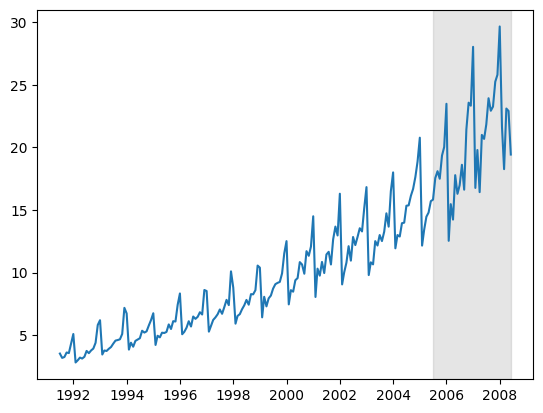

In [10]:
# entrenamiento y prueba
train = df[:-36]
test = df[-36:]


fig, ax = plt.subplots()
ax.plot(df.index, df['y'], label='actual')
inicio = df.index[-36]
fin = df.index[-1]
# Resaltar la zona de test
ax.axvspan(inicio, fin, color='#808080', alpha=0.2)

Prepara todas las configuraciones posibles de parámetros SARIMA donde cada parámetro puede valer entre 0 y 6.

In [11]:
from itertools import product

ps = range(0, 5, 1) #1
qs = range(0, 5, 1)
Ps = range(0, 5, 1)
Qs = range(0, 5, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

Definamos la función que evaluar los modelos SARIMA.

1. El parámetro order_list ahora incluye órdenes p, q, P y Q. También añadimos el orden estacional de diferenciación D y la frecuencia. Recuerda que la frecuencia m en el modelo SARIMA se denota como s en la implementación de la biblioteca statsmodels.
2. Recorra todos los modelos únicos SARIMA(p,d,q)(P,D,Q)m, ajústelos y almacene los AIC.
3. Devuelve el DataFrame ordenado, comenzando con el AIC más bajo.

In [12]:
from typing import Union
from tqdm.notebook import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame: #1
    results = []
    for order in tqdm(order_list): #2
        try:
            model = SARIMAX(
                endog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
        aic = model.aic
        results.append([order, aic])
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return result_df #3

Definamos los parametros de diferenciación, diferenciación estacional y frecuencia encontrados y ejecutemos la función. Recordemos que la serie alcazó la estacionariedad con:
- d=1
- D=1
- m=12

In [13]:
d = 1 
D = 1
s = 12
SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, s)#4
SARIMA_result_df

  0%|          | 0/625 [00:00<?, ?it/s]

/home/luisgarcia/anaconda3/envs/Series_TF/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/luisgarcia/anaconda3/envs/Series_TF/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/luisgarcia/anaconda3/envs/Series_TF/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/luisgarcia/anaconda3/envs/Series_TF/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/luisgarcia/anaconda3/envs/Series_TF/lib/python3.12/site-pa

,"(p,q,P,Q)",AIC
0,"(3, 1, 1, 3)",270.951096
1,"(2, 4, 1, 3)",271.214990
2,"(3, 3, 1, 3)",271.460516
3,"(4, 1, 1, 3)",272.145293
4,"(0, 4, 1, 3)",272.152380
...,...,...
619,"(0, 0, 0, 4)",351.680917
620,"(0, 0, 2, 4)",353.250657
621,"(0, 0, 0, 1)",354.751719
622,"(0, 0, 1, 0)",357.173706


Esto devuelve un DataFrame donde el modelo con el AIC más bajo es un modelo SARIMA(3,1,1)(1,1,3)12

/home/luisgarcia/anaconda3/envs/Series_TF/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/luisgarcia/anaconda3/envs/Series_TF/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


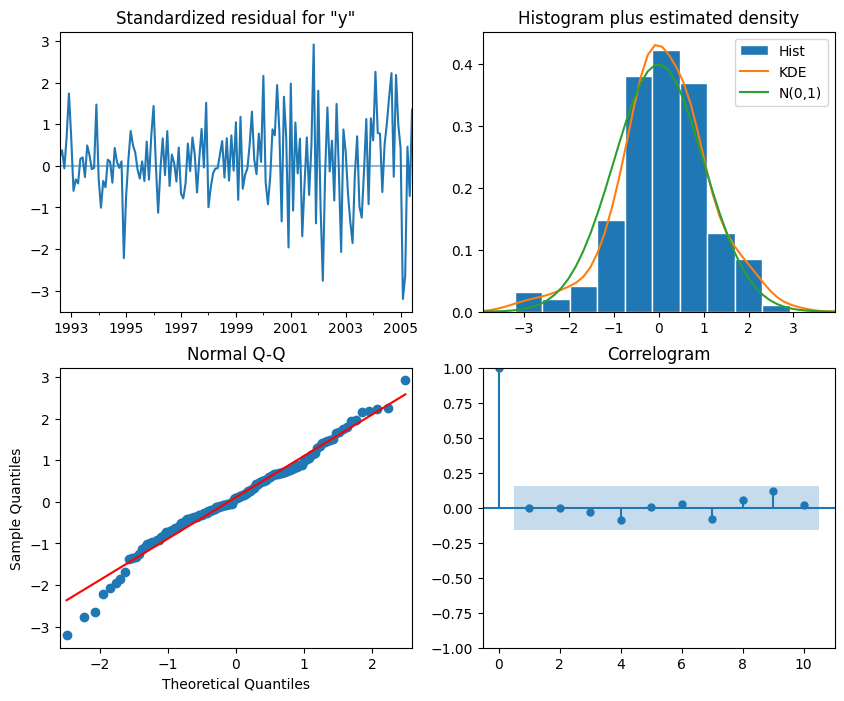

In [14]:
SARIMA_model = SARIMAX(train, order=(3,1,1), seasonal_order=(1,1,3,12),simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

Diagnósticos visuales de los residuos. En el gráfico de la parte superior izquierda, los residuos no tienen tendencia a lo largo del tiempo, y la varianza parece constante. En la parte superior derecha, la distribución de los residuos es muy cercana a una distribución normal. Esto se apoya aún más en el gráfico Q-Q en la parte inferior izquierda, que muestra una línea bastante recta que se encuentra en y = x. Finalmente, el correlograma en la parte inferior derecha no muestra coeficientes significativos después del retraso 0, igual que el ruido blanco.

El siguiente paso es realizar la prueba de Ljung-Box, que determina si los residuos son independientes y no correlacionados. La hipótesis nula de la prueba de Ljung-Box establece que los residuos son no correlacionados, al igual que el ruido blanco. Por lo tanto, queremos que la prueba devuelva valores p mayores que 0.05. En ese caso, no podemos rechazar la hipótesis nula y concluir que nuestros residuos son independientes y, por lo tanto, se comportan como ruido blanco.

In [15]:
from statsmodels.stats.diagnostic import acorr_ljungbox
residuals = SARIMA_model_fit.resid
lb_test = acorr_ljungbox(residuals, lags=np.arange(1, 11))  
# Extraer solo los p-values como array
pvalue = lb_test["lb_pvalue"].values
print(pvalue)

[0.50877178 0.73083055 0.88589399 0.68848325 0.70775195 0.75873676
 0.18964607 0.2259686  0.22173785 0.28611909]


En este caso, todos los valores p están por encima de 0.05, por lo que no rechazamos la hipótesis nula, y concluimos que los residuos son independientes y no correlacionados. Podemos concluir que el modelo puede ser utilizado para pronósticos.

# Forescating

Tenemos un modelo que se puede utilizar para pronósticos, así que ahora `realizaremos pronósticos continuos de 12 meses sobre el conjunto de prueba de 36 meses`. De esa manera, tendremos una mejor evaluación del rendimiento de nuestro modelo, ya que probar con menos puntos de datos podría dar lugar a resultados sesgados. Utilizaremos el pronóstico estacional ingenuo como línea de base; simplemente tomará los últimos 12 meses de datos y los usará como pronósticos para los próximos 12 meses.

In [16]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int,window: int, method: str) -> list:
    total_len = train_len + horizon
    end_idx = train_len
    if method == 'last_season':
        pred_last_season = []
        for i in range(train_len, total_len, window):
            last_season = df['y'][i-window:i].values
            pred_last_season.extend(last_season)
        return pred_last_season
    elif method == 'SARIMA':
        pred_SARIMA = []
        for i in range(train_len, total_len, window):
            model = SARIMAX(df['y'][:i], order=(3,1,1),
            seasonal_order=(1,1,3,12), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMA.extend(oos_pred)
        return pred_SARIMA

Ahora podemos definir los parámetros que se utilizarán para la función rolling_forecast. El conjunto de datos contiene 204 filas y el conjunto de prueba contiene 36 puntos de datos, lo que significa que la longitud del conjunto de entrenamiento es 204 - 36 = 168. `El horizonte es 36, ya que nuestro conjunto de prueba contiene 36 meses de datos`. Finalmente, `la ventana es de 12 meses, ya que estamos pronosticando 12 meses a la vez`.

Con esos valores establecidos, podemos registrar las predicciones provenientes de nuestra línea base, que es un pronóstico estacional ingenuo. Simplemente toma los últimos 12 meses de datos observados y los utiliza como pronósticos para los próximos 12 meses.

In [18]:
TRAIN_LEN = 168 # longitud de datos de entrenamient
HORIZON = 36 # es la longitud de los datos de prieba
WINDOW = 12 # se pronostican 12 meses a la vez.

pred_df = test.copy()
pred_df['last_season'] = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW,'last_season')
pred_df['SARIMA'] = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW,'SARIMA')

/home/luisgarcia/anaconda3/envs/Series_TF/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/luisgarcia/anaconda3/envs/Series_TF/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/luisgarcia/anaconda3/envs/Series_TF/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/luisgarcia/anaconda3/envs/Series_TF/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/luisgarcia/anaconda3/envs/Series_TF/lib/python3.12/site-pa

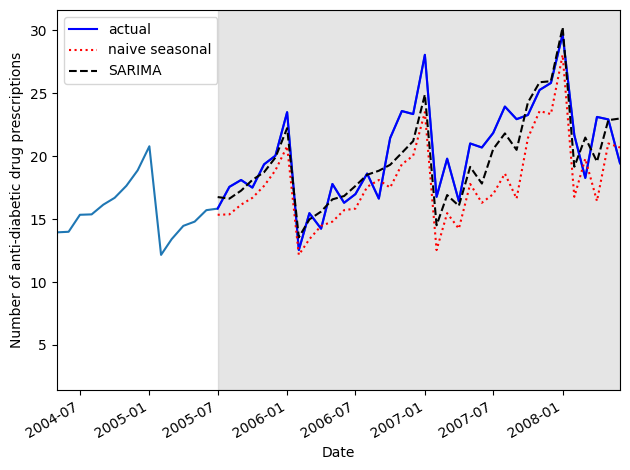

In [21]:
fig, ax = plt.subplots()
ax.plot(df.y)
ax.plot(pred_df.y, 'b-', label='actual')
ax.plot(pred_df.last_season, 'r:', label='naive seasonal')
ax.plot(pred_df.SARIMA, 'k--', label='SARIMA')
ax.set_xlabel('Date')
ax.set_ylabel('Number of anti-diabetic drug prescriptions')
inicio = df.index[-36]
fin = df.index[-1]
# Resaltar la zona de test
ax.axvspan(inicio, fin, color='#808080', alpha=0.2)
ax.legend(loc=2)
#plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))
plt.xlim(df.index[-50], df.index[-1])
fig.autofmt_xdate()
plt.tight_layout()

Pronósticos del número de recetas de medicamentos antidiabéticos en Australia. Las predicciones desde la línea base se muestran como una línea de puntos, mientras que las predicciones del modelo SARIMA se muestran como una línea discontinua.

En la figura, puedes ver que las predicciones del modelo SARIMA (la línea discontinua) siguen los valores reales más de cerca que las previsiones estacionales ingenuas (la línea punteada). Por lo tanto, podemos esperar intuitivamente que el modelo SARIMA haya tenido un mejor rendimiento que el método base.

Para evaluar el rendimiento de manera cuantitativa, usaremos el error porcentual absoluto medio (MAPE). El MAPE es fácil de interpretar, ya que devuelve un error porcentual.

In [23]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_naive_seasonal = mape(pred_df.y, pred_df.last_season)
mape_SARIMA = mape(pred_df.y, pred_df.SARIMA)
print(mape_naive_seasonal, mape_SARIMA)

12.686561923100614 7.563305711329539


Esto imprime un MAPE del 12.69% para la línea base y del 7.56% para el modelo SARIMA. Opcionalmente, podemos trazar el MAPE de cada modelo en un gráfico de barras para una buena visualización.

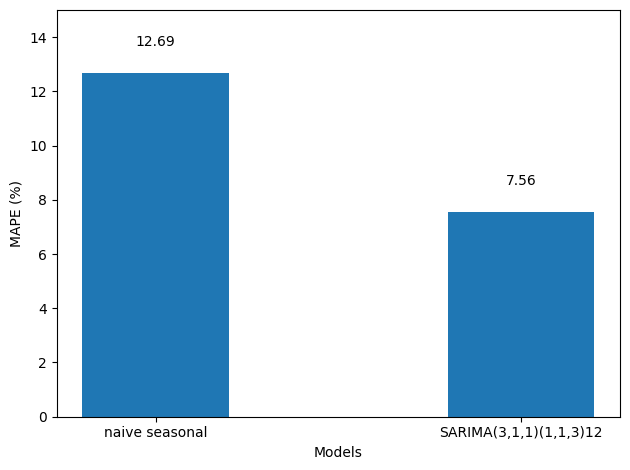

In [26]:
fig, ax = plt.subplots()
x = ['naive seasonal', 'SARIMA(3,1,1)(1,1,3)12']
y = [mape_naive_seasonal, mape_SARIMA]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)
for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')
    plt.tight_layout()

Dado que el modelo SARIMA logra el MAPE más bajo, podemos concluir que el modelo SARIMA(2,1,3)(1,1,3)12 debe ser utilizado para prever el número mensual de recetas de medicamentos antidiabéticos en Australia.